## Data pre-processing

### Imports

In [23]:
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from scipy.optimize import curve_fit

### Load Demographic data

In [7]:
sheet_url = "https://docs.google.com/spreadsheets/d/1H9DApYyqdZ0iVAvFKBodHrH654K0NwKzldf5xz5m2tc/edit#gid=1885121359"
url_demographic = sheet_url.replace("/edit#gid=", "/export?format=csv&gid=")
data_demographic = pd.read_csv(url_demographic)
data_demographic

,Marca temporal,Código de participante,He sido informado sobre la naturaleza del estudio y doy mi consentimiento para participar:,Sexo,Edad (en años),Nivel educativo,Ocupación,"¿Tienes historial de trastornos neurológicos? (Ejem. afasia, dislexia, etc.)","¿Has sido diagnosticada/o con alguna de las siguientes condiciones? (De ser así, por favor marca las opciones correspondientes).",¿Presentas problemas de visión sin corregir?,...,1. Muchas veces noto pequeños sonidos en los que otros no reparan.,"2. Por lo general me concentro más en ""la imagen completa"", en lugar de en los pequeños detalles.",3. Me resulta fácil hacer más de una cosa a la vez.,"4. Si hay una interrupción, puedo volver a concentrarme en lo que estaba haciendo muy rápido.","5. Me resulta fácil ""leer entre líneas"" cuando alguien me está hablando.",6. Sé cómo saber si alguien que me escucha se está aburriendo.,"7. Cuando estoy leyendo una historia, me resulta difícil descifrar las intenciones de los personajes.","8. Me gusta recabar información sobre categorías de cosas (por ejemplo: tipos de automóviles, tipos de aves, tipos de trenes, tipos de plantas, etc.)",9. Me resulta fácil saber lo que alguien está pensando o sintiendo simplemente mirando su rostro.,10. Me resulta difícil comprender las intenciones de las personas.
0,30/1/2024 10:34:23,P01,NaN,Femenino,23,Universitario incompleto,Universitaria,No,No,No,...,1,4,3,3,3,3,1,1,3,3
1,30/1/2024 12:30:34,P02,NaN,Femenino,21,Universitario incompleto,estudiante,Si,Trastorno de Déficit de Atención,No,...,1,1,4,3,1,2,1,4,4,4
2,30/1/2024 14:13:03,P03,NaN,Masculino,21,Universitario incompleto,Estudiante,No,No,Si,...,3,2,4,2,2,4,3,4,3,3
3,30/1/2024 15:33:06,P04,NaN,Masculino,21,Universitario incompleto,Estudiante,No,Trastorno del Espectro Autista,No,...,4,1,1,2,2,3,1,4,2,4
4,13/3/2024 16:33:02,A01,NaN,SEMIHOMBRE,21,Universitario incompleto,ESTUDIANTE,No,No,Si,...,1,3,3,3,3,4,2,2,3,2
5,13/3/2024 16:55:09,A02,NaN,Femenino,20,Universitario incompleto,estudiante,No,No,Si,...,2,3,3,2,2,2,1,2,3,3
6,14/3/2024 13:05:59,a03,NaN,Femenino,25,Universitario incompleto,Estudiante,Si,Trastorno de Déficit de Atención,Si,...,3,2,3,1,2,3,2,4,3,3
7,21/3/2024 16:52:02,AC01,Sí,Femenino,17,Universitario incompleto,Estudiante,No,No,No,...,2,2,3,4,3,4,1,4,2,2
8,22/3/2024 9:09:53,AC02,Sí,Femenino,16,Universitario incompleto,Estudiante de ingeniería,No,No,Si,...,3,2,3,4,2,4,2,3,4,2
9,22/3/2024 9:59:59,AC03,Sí,Femenino,17,Secundaria completa,Estudiante,No,No,No,...,3,2,3,3,2,4,2,2,3,2


### Load DFI data

In [8]:
# Get participant files name
participant_files = []
for p in Path("./data_ac").glob("*.csv"):
    participant_files.append(f"{p.name}")

# Create empty DataFrame
data_dfi = pd.DataFrame()

# Compute data for each participant
for participant_file in participant_files:
    data = pd.read_csv("data_ac/" + participant_file)
    data = data[
        [
            "participant",
            "SOA",
            "confidence_slider.response",
            "confidence_slider.rt",
            "key_resp.keys",
            "key_resp.rt",
        ]
    ]
    data = data.dropna()

    par_df = pd.DataFrame()

    for soa in data.SOA.unique():
        soa_df = data.query("SOA == @soa")
        confidence = soa_df["confidence_slider.response"].mean()

        confidence_rt = soa_df["confidence_slider.rt"].mean()
        two_flashes = soa_df[soa_df["key_resp.keys"] == "num_2"].shape[0]
        two_flashes_rt = soa_df["key_resp.rt"].mean()

        par = {
            "Participant": data.participant.iloc[-1],
            "SOA": soa,
            "Confidence": confidence,
            "Illusion_count": two_flashes,
            "Confidence_RT": confidence_rt,
            "Illusion_count_RT": two_flashes_rt,
        }

        new_df = pd.DataFrame(data=par, index=[soa])
        par_df = pd.concat([par_df, new_df], ignore_index=True)

    # Append to final Dataframe
    data_dfi = pd.concat([data_dfi, par_df], ignore_index=True)

data_dfi

,Participant,SOA,Confidence,Illusion_count,Confidence_RT,Illusion_count_RT
0,AC04,14.0,93.750,2,0.891122,1.008787
1,AC04,12.0,93.343,1,1.529404,1.173780
2,AC04,10.0,91.562,5,0.752776,1.089190
3,AC04,8.0,95.760,9,0.759503,1.084191
4,AC04,4.0,97.541,8,0.822896,1.159290
...,...,...,...,...,...,...
280,ac13,2.0,86.697,10,1.294362,1.752465
281,ac13,15.0,92.729,0,1.454383,1.075611
282,ac13,14.0,89.054,0,1.471058,1.027001
283,ac13,12.0,88.511,0,1.324367,1.080806


### Load Audiometry data

In [9]:
sheet_url = "https://docs.google.com/spreadsheets/d/1fNNucIiKoI6WyVRBQCq-m2NgCjLb-PdJ_W8OI22_Znc/edit#gid=0"
url_pure_tone = sheet_url.replace("/edit#gid=", "/export?format=csv&gid=")
data_pure_tone = pd.read_csv(url_pure_tone)
data_pure_tone

,Participant ID,Ear,Frequency (Hz),Hearing Level (dB),Date,Evaluator
0,AC01,R,1000,20,21/03,Fernando
1,AC01,R,2000,10,21/03,Fernando
2,AC01,R,4000,15,21/03,Fernando
3,AC01,R,8000,5,21/03,Fernando
4,AC01,R,500,20,21/03,Fernando
5,AC01,R,250,20,21/03,Fernando
6,AC01,L,1000,10,21/03,Fernando
7,AC01,L,2000,10,21/03,Fernando
8,AC01,L,4000,15,21/03,Fernando
9,AC01,L,8000,20,21/03,Fernando


In [10]:
sheet_url = "https://docs.google.com/spreadsheets/d/1fNNucIiKoI6WyVRBQCq-m2NgCjLb-PdJ_W8OI22_Znc/edit#gid=309462883"
url_ldl = sheet_url.replace("/edit#gid=", "/export?format=csv&gid=")
data_ldl = pd.read_csv(url_ldl)
data_ldl

,Participant ID,Ear,Frequency (Hz),Start (dB),LDL (dB),Date,Evaluator
0,AC01,L,1000,10,70,21/03,Fernando
1,AC01,L,2000,10,70,21/03,Fernando
2,AC01,L,4000,15,50,21/03,Fernando
3,AC01,L,8000,20,55,21/03,Fernando
4,AC01,L,500,10,60,21/03,Fernando
5,AC01,L,250,10,60,21/03,Fernando
6,AC09,R,1000,10,90,25/03,Paola
7,AC09,R,2000,5,95,25/03,Paola
8,AC09,R,4000,5,105,25/03,Paola
9,AC09,R,8000,5,100,25/03,Paola


### Sigmoid fit to obtain TWI

In [79]:
def sig(x, a, b, c, d):
    """Compute sigmoidal value for the given delay.
    Args:
        x (1D np.array): Delay (ms).
        a (number): upper asymptote of the sigmoid.
        b (number): lower asymptote of the sigmoid.
        c (number): Central point of the sigmoid.
        d (number): Slope parameter of the sigmoid (slope = 1/d).

    Returns:
        sig (1D np.array): Vector with values for the given delay points.
    """
    return a + b / (1 + np.exp(-(x - c) / d))


def alter_sig(x, c, d):
    """Compute sigmoidal value for the given delay.
    Args:
        x (1D np.array): Delay (ms).
        a (number): upper asymptote of the sigmoid.
        b (number): lower asymptote of the sigmoid.
        c (number): Central point of the sigmoid.
        d (number): Slope parameter of the sigmoid (slope = 1/d).

    Returns:
        sig (1D np.array): Vector with values for the given delay points.
    """
    global a
    global b

    return a + b / (1 + np.exp(-(x - c) / d))


## Sigmoid function fitting
def sigfit(x, y):
    """Fit the RT data to a sigmoidal function.

    Args:
        x (1D np.array): Delay (ms).
        y (1D np.array) : Values for the given delay points.

    Returns:
        a (number): upper asymptote of the sigmoid.
        b (number): lower asymptote of the sigmoid.
        c (number): Central point of the sigmoid.
        d (number): Slope parameter of the sigmoid (slope = 1/d).
    """

    # Obtains the upper and lower bounds
    a = np.max(y)
    b = np.min(y)

    # Defines starting points and boundaries for the fitting
    k_0 = (a - b) / (x[-1] - x[0])
    initial_slope = -(a - b) / (4 * k_0)
    # if initial_slope>=0: initial_slope=-0.0001
    middle_x = np.max(x) / 2
    init_guess = [a, b, middle_x, initial_slope]
    boundaries = ([0, 0, 34, float("-inf")], [100, 100, 272, 0])

    # Fits the data
    popt, _ = curve_fit(
        sig,
        x,
        y,
        p0=init_guess,
        method="trf",
        ftol=1e-8,
        xtol=1e-8,
        maxfev=100000,
        bounds=boundaries,
    )
    sigpar = np.asarray(popt)
    a = sigpar[0]
    b = sigpar[1]
    c = sigpar[2]
    d = sigpar[3]

    return a, b, c, d


def alter_sigfit(x, y):
    """Fit the RT data to a sigmoidal function.

    Args:
        x (1D np.array): Delay (ms).
        y (1D np.array) : Values for the given delay points.

    Returns:
        a (number): upper asymptote of the sigmoid.
        b (number): lower asymptote of the sigmoid.
        c (number): Central point of the sigmoid.
        d (number): Slope parameter of the sigmoid (slope = 1/d).
    """

    # Obtains the upper and lower bounds
    global a
    global b

    # Defines starting points and boundaries for the fitting
    k_0 = (a - b) / (x[-1] - x[0])
    initial_slope = -(a - b) / (4 * k_0)
    middle_x = np.max(x) / 2
    init_guess = [middle_x, initial_slope]
    boundaries = ([34, float("-inf")], [272, 0])

    # Fits the data
    popt, _ = curve_fit(
        alter_sig,
        x,
        y,
        p0=init_guess,
        method="trf",
        ftol=1e-8,
        xtol=1e-8,
        maxfev=100000,
        bounds=boundaries,
    )
    sigpar = np.asarray(popt)
    c = sigpar[0]
    d = sigpar[1]

    return c, d


participant_data = data_dfi.query("Participant == 'AC05'").sort_values("SOA")
participant_data_illusion = participant_data.Illusion_count.values * 10
soas = participant_data.SOA.values * 17

# Fitting procedure
a, b, participant_twi, participant_slope = sigfit(soas, participant_data_illusion)
participant_sigmoid_data = sig(soas, a, b, participant_twi, participant_slope)

# Alternative fitting procedure
a, b = np.min(participant_data_illusion), np.max(participant_data_illusion)
participant_twi_alter, participant_slope_alter = alter_sigfit(
    soas, participant_data_illusion
)
participant_sigmoid_data_alter = alter_sig(soas, participant_twi, participant_slope)

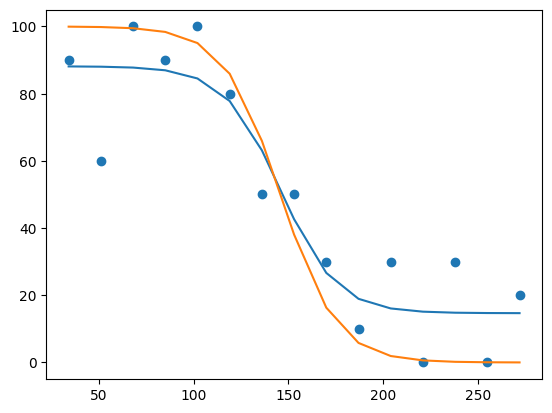

In [80]:
import matplotlib.pyplot as plt

plt.scatter(soas, participant_data_illusion)
plt.plot(soas, participant_sigmoid_data)
plt.plot(soas, participant_sigmoid_data_alter)

## Group Results

<Axes: xlabel='SOA', ylabel='Illusion_count'>

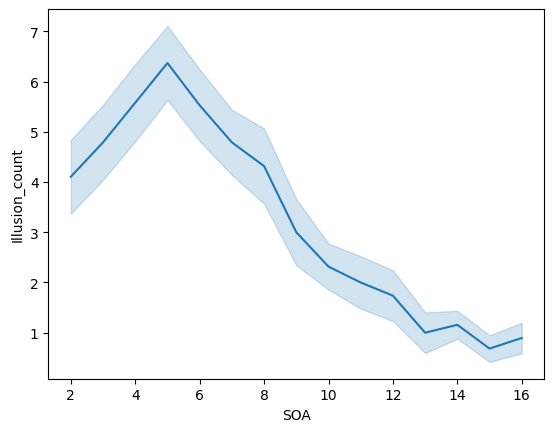

In [13]:
sns.lineplot(x="SOA", y="Illusion_count", data=data_dfi, errorbar="se")